In [1]:

import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,CustomerID,Gender,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
X = abt.drop(["CustomerID","Churn"], axis=1)

y = abt["Churn"]

# display shapes of X and y
print(X.shape, y.shape)

(6499, 19) (6499,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['Gender', 'Senior_Citizen', 'Tenure', 'Monthly_Charges', 'Total_Charges']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method']

In [6]:
# distribution of churn
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Churn':col1,'Churn %':col2.round(2)})

,Target,Churn,Churn %
0,0,4784,73.61
1,1,1715,26.39


## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Churn)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

4549 1950 4549 1950


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4549 entries, 736 to 5374
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             4549 non-null   int64  
 1   Senior_Citizen     4549 non-null   int64  
 2   Partner            4549 non-null   object 
 3   Dependents         4549 non-null   object 
 4   Tenure             4549 non-null   int64  
 5   Phone_Service      4549 non-null   object 
 6   Multiple_Lines     4549 non-null   object 
 7   Internet_Service   4549 non-null   object 
 8   Online_Security    4549 non-null   object 
 9   Online_Backup      4549 non-null   object 
 10  Device_Protection  4549 non-null   object 
 11  Tech_Support       4549 non-null   object 
 12  Streaming_TV       4549 non-null   object 
 13  Streaming_Movies   4549 non-null   object 
 14  Contract           4549 non-null   object 
 15  Paperless_Billing  4549 non-null   object 
 16  Payment_Method     454

## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 4, 17, 18]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 4, 17, 18]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                  16])])

In [12]:
# Import classifier
from sklearn.neighbors import KNeighborsClassifier

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  KNeighborsClassifier())

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 4, 17, 18]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [2, 3, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16])])),
                ('smote', SMOTE(random_state=10)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [13]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
kn_param_grid = {
    'kneighborsclassifier__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'kneighborsclassifier__weights' : ['uniform', 'distance'],
    'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
kn_grid = GridSearchCV(model, kn_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [14]:
kn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.673 total time=   2.2s
[CV 2/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.704 total time=   1.2s
[CV 3/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.704 total time=   1.1s
[CV 4/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.691 total time=   1.1s
[CV 5/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.696 total time=   1.1s
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance;, score=0.673 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          4, 17,
                                                                          18]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [2, 3,
                                                                          5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               20, 21, 22, 23,
                                                               24, 25, 26, 27,
                                                               28, 29, 30],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy', verbose=3)

In [15]:
print(kn_grid.best_params_)

{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__weights': 'uniform'}


In [16]:
print(kn_grid.best_score_)

0.7194992686081795


In [17]:
print(f"Training Data Score: {kn_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {kn_grid.score(X_test, y_test)}")

Training Data Score: 0.8700813365574852
Testing Data Score: 0.7153846153846154


In [18]:
predictions = kn_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 0 1 0 0 1 0 0 0 0]
First 10 Actual labels: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [19]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
1945,0,0
1946,1,1
1947,0,0
1948,0,0


In [20]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[1092  343]
 [ 212  303]]


In [21]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.76 0.24]
 [0.41 0.59]]


In [22]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1435
           1       0.47      0.59      0.52       515

    accuracy                           0.72      1950
   macro avg       0.65      0.67      0.66      1950
weighted avg       0.74      0.72      0.72      1950



In [23]:
pred = kn_grid.predict(X_test[:1])

In [24]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [1]


In [26]:
import joblib

filename = '../models/challa_knn.sav'
joblib.dump(kn_grid, filename)

['../models/challa_knn.sav']

In [27]:
kn_model = joblib.load(filename)
print(kn_model.score(X_test, y_test))

0.7153846153846154


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [29]:
model_performance_classification_sklearn(kn_grid, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.870081,0.854167,0.711312,0.776221


In [30]:
model_performance_classification_sklearn(kn_grid, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.715385,0.58835,0.46904,0.521964


In [31]:
df1 = pd.DataFrame(model_performance_classification_sklearn(kn_grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.715385
1,Recall,0.588350
2,Precision,0.469040
3,F1,0.521964


In [32]:
df2 = pd.DataFrame(model_performance_classification_sklearn(kn_grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.870081
1,Recall,0.854167
2,Precision,0.711312
3,F1,0.776221


In [33]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.870081,0.715385
1,Recall,0.854167,0.588350
2,Precision,0.711312,0.469040
3,F1,0.776221,0.521964


In [34]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

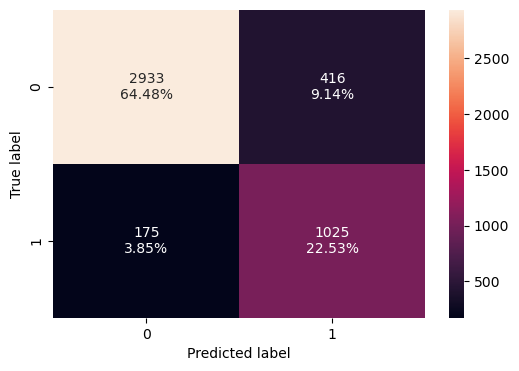

In [35]:
confusion_matrix_sklearn(kn_grid, X_train, y_train)

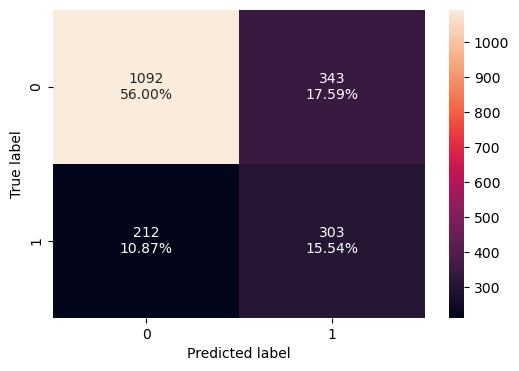

In [37]:
confusion_matrix_sklearn(kn_grid, X_test, y_test)